In [25]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import uuid
import pickle
#Dataset from : - https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes?resource=download
# Set random seed for reproducibility
np.random.seed(42)

In [76]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = ""
        self.df = None
        self.quotes = ["Stay healthy", "Live well", "Stay active", "Eat balanced", "Keep calm"]
        self.cities = ["New York", "Los Angeles", "Chicago", "Houston", "Phoenix"]
        self.outcome_mapping = {0: "No Diabetes", 1: "Diabetes"}

    def fetch_dataset(self, file_path):
        self.df = pl.read_csv(self.file_path)
        self.df = self.df.with_columns([
            pl.Series("Quote", np.random.choice(self.quotes, size=self.df.height)).cast(pl.Utf8),
            pl.Series("City", np.random.choice(self.cities, size=self.df.height)).cast(pl.Utf8)
        ])

    def __printShape(self):
        print("Dataset Shape:", self.df.shape)

    def _printHead(self):
        print("Dataset Head:")
        print(self.df.head())

    @staticmethod
    def editAttribute(self):
        self.df = self.df.with_columns(
            pl.col("Outcome").map_elements(lambda x: self.outcome_mapping.get(x, None)).cast(pl.Utf8).alias("Outcome")
        )

    def load_dataset(self, file_path):
        self.file_path = file_path
        self.fetch_dataset(file_path)
        self.editAttribute(self)
        self.__printShape()
        return self.df

    def __del__(self):
        print(f"DataLoader Object Deleted with file_path, quotes, cities, outcome_mapping. ")

In [77]:
dl=DataLoader("/content/Healthcare-Diabetes.csv")
df=dl.load_dataset("/content/Healthcare-Diabetes.csv")
dl._printHead()

DataLoader Object Deleted with file_path, quotes, cities, outcome_mapping. 
Dataset Shape: (2768, 12)
Dataset Head:
shape: (5, 12)
┌─────┬─────────────┬─────────┬───────────────┬───┬─────┬─────────────┬──────────────┬─────────────┐
│ Id  ┆ Pregnancies ┆ Glucose ┆ BloodPressure ┆ … ┆ Age ┆ Outcome     ┆ Quote        ┆ City        │
│ --- ┆ ---         ┆ ---     ┆ ---           ┆   ┆ --- ┆ ---         ┆ ---          ┆ ---         │
│ i64 ┆ i64         ┆ i64     ┆ i64           ┆   ┆ i64 ┆ str         ┆ str          ┆ str         │
╞═════╪═════════════╪═════════╪═══════════════╪═══╪═════╪═════════════╪══════════════╪═════════════╡
│ 1   ┆ 6           ┆ 148     ┆ 72            ┆ … ┆ 50  ┆ Diabetes    ┆ Live well    ┆ Houston     │
│ 2   ┆ 1           ┆ 85      ┆ 66            ┆ … ┆ 31  ┆ No Diabetes ┆ Keep calm    ┆ Los Angeles │
│ 3   ┆ 8           ┆ 183     ┆ 64            ┆ … ┆ 32  ┆ Diabetes    ┆ Keep calm    ┆ Chicago     │
│ 4   ┆ 1           ┆ 89      ┆ 66            ┆ … ┆ 21  ┆ No 

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


In [78]:
#printing shape through Name mangling
dl._DataLoader__printShape()
dl.__del__()

Dataset Shape: (2768, 12)
DataLoader Object Deleted with file_path, quotes, cities, outcome_mapping. 


In [79]:
df.shape

(2768, 12)

In [80]:
class DataCleaner:
    def __init__(self, df):
        self.df = df
        self.numeric_cols=[]

    @classmethod
    def check_count(cls):
        print("Null counts:\n", df.null_count())

    def replace_null(self):
      # Replace nulls with mean for numeric columns
      self.numeric_cols = [col for col, dtype in zip(self.df.columns, self.df.dtypes) if dtype in [pl.Float64, pl.Int64]]
      for col in self.numeric_cols:
          if self.df[col].null_count() > 0:
              self.df = self.df.with_columns(
                  pl.col(col).fill_null(pl.col(col).mean()).alias(col)
              )

    def __printHead(self):
        print("Dataset Head:")
        print(self.df.head())

    def __printShape(self):
        print("Dataset Shape:", self.df.height, self.df.width)

    def _check_remove_duplicates(self):
        print("Duplicate rows:", self.df.is_duplicated().sum())
        self.df = self.df.unique()

    def cleanData(self):
        self.check_count()
        self.replace_null()
        self._check_remove_duplicates()
        self.__printShape()
        return self.df

    def __del__(self):
        print("DataCleaner object deleted")

In [81]:
class DataOutlier(DataCleaner):
    def __init__(self, df):
        super().__init__(df)
        self.df=self.cleanData()
        self.df_pandas = self.df.to_pandas()
        self.threshold = 3

    def cal_z_score(self):
        z_scores = np.abs(stats.zscore(self.df_pandas[self.numeric_cols]))
        outlier_mask = (z_scores < self.threshold).all(axis=1)
        return outlier_mask

    def _printOutlier(self):
        print("Calculate Outlier:", self.cal_z_score())

    @staticmethod
    def statistical_info(self):
        print("Statistical summary:\n", self.df.describe())

    def remove_outliers(self):
        outlier_mask = self.cal_z_score()
        self.df_pandas = self.df_pandas[outlier_mask]
        print(self.df_pandas.head(2))
        self._printOutlier()
        return pl.from_pandas(self.df_pandas)

    def __del__(self):
        print("DataOutlier object deleted")

In [82]:
class DataNormaliseStandardise(DataOutlier):
    def __init__(self, df):
        super().__init__(df)
        self.df=self.remove_outliers()
        self.categorical_cols = ['Quote', 'City', 'Outcome']
        self.le = LabelEncoder()
        self.original_mappings = {}
        self.scaler = StandardScaler()

    def normaliseCatagoricalLabel(self):
        for col in self.categorical_cols:
          self.df = self.df.with_columns(
              pl.Series(col, self.le.fit_transform(self.df[col].to_pandas())).cast(pl.UInt32).alias(col)
          )
          self.original_mappings[col] = dict(zip(self.le.classes_, range(len(self.le.classes_))))
        print("\n",self.df.head(2),"\nLabel Encoded mappings:", self.original_mappings)
        #print statistial info from parent class
        super().statistical_info(self)

    def sort_rearrange(self):
      print(f"Sort By Age: {np.array(self.df['Age'].unique().sort())}")

    def __showHead(self):
      print(self.df.head(2), "\n\nRearrange by BloodPressure:")
      print(self.df.with_columns(pl.col("BloodPressure").cast(pl.UInt32).alias("BloodPressure_encoded")).head(2))
      print("\n",pl.Categorical)

    def preprocess_standardise(self):
        #Normalise
        self.normaliseCatagoricalLabel()
        self.df_pandas = self.df.to_pandas()
        # Standard Scaling
        self.df_pandas[self.numeric_cols] = self.scaler.fit_transform(self.df_pandas[self.numeric_cols])
        self.sort_rearrange()
        return pl.from_pandas(self.df_pandas)

    def __del__(self):
        # Save StandardScaler
        with open("scaler.pkl", "wb") as f:
            pickle.dump(dns.scaler, f)
        print("DataNormaliseStandardise object deleted")

In [83]:
dns=DataNormaliseStandardise(df)
df=dns.preprocess_standardise()
dns._DataCleaner__printShape()

Null counts:
 shape: (1, 12)
┌─────┬─────────────┬─────────┬───────────────┬───┬─────┬─────────┬───────┬──────┐
│ Id  ┆ Pregnancies ┆ Glucose ┆ BloodPressure ┆ … ┆ Age ┆ Outcome ┆ Quote ┆ City │
│ --- ┆ ---         ┆ ---     ┆ ---           ┆   ┆ --- ┆ ---     ┆ ---   ┆ ---  │
│ u32 ┆ u32         ┆ u32     ┆ u32           ┆   ┆ u32 ┆ u32     ┆ u32   ┆ u32  │
╞═════╪═════════════╪═════════╪═══════════════╪═══╪═════╪═════════╪═══════╪══════╡
│ 0   ┆ 0           ┆ 0       ┆ 0             ┆ … ┆ 0   ┆ 0       ┆ 0     ┆ 0    │
└─────┴─────────────┴─────────┴───────────────┴───┴─────┴─────────┴───────┴──────┘
Duplicate rows: 0
Dataset Shape: 2768 12
     Id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0  1233           10      115             98              0        0  24.0   
1  2036            0       95             85             25       36  37.4   

   DiabetesPedigreeFunction  Age      Outcome         Quote         City  
0                     1.022   34  No Di

In [84]:
dns._DataNormaliseStandardise__showHead()
# Save LabelEncoders (we reconstruct them from `original_mappings`)
label_encoders = {}
for col in dns.categorical_cols:
    le = LabelEncoder()
    le.classes_ = np.array(list(dns.original_mappings[col].keys()))
    label_encoders[col] = le

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

dns.__del__()

shape: (2, 12)
┌──────┬─────────────┬─────────┬───────────────┬───┬─────┬─────────┬───────┬──────┐
│ Id   ┆ Pregnancies ┆ Glucose ┆ BloodPressure ┆ … ┆ Age ┆ Outcome ┆ Quote ┆ City │
│ ---  ┆ ---         ┆ ---     ┆ ---           ┆   ┆ --- ┆ ---     ┆ ---   ┆ ---  │
│ i64  ┆ i64         ┆ i64     ┆ i64           ┆   ┆ i64 ┆ u32     ┆ u32   ┆ u32  │
╞══════╪═════════════╪═════════╪═══════════════╪═══╪═════╪═════════╪═══════╪══════╡
│ 1233 ┆ 10          ┆ 115     ┆ 98            ┆ … ┆ 34  ┆ 1       ┆ 1     ┆ 2    │
│ 2036 ┆ 0           ┆ 95      ┆ 85            ┆ … ┆ 24  ┆ 0       ┆ 4     ┆ 2    │
└──────┴─────────────┴─────────┴───────────────┴───┴─────┴─────────┴───────┴──────┘ 

Rearrange by BloodPressure:
shape: (2, 13)
┌──────┬─────────────┬─────────┬───────────────┬───┬─────────┬───────┬──────┬──────────────────────┐
│ Id   ┆ Pregnancies ┆ Glucose ┆ BloodPressure ┆ … ┆ Outcome ┆ Quote ┆ City ┆ BloodPressure_encode │
│ ---  ┆ ---         ┆ ---     ┆ ---           ┆   ┆ ---     ┆ ---

In [85]:
df.head()

Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Quote,City
f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,u32
-0.191013,1.940449,-0.183207,2.104947,-1.372169,-0.817307,-1.243157,2.014529,0.084954,1,1,2
0.815294,-1.158514,-0.847928,1.041242,0.256918,-0.417025,0.773973,-0.735292,-0.787121,0,4,2
-0.24114,1.320656,1.01329,0.468478,0.713063,1.517671,1.6019,0.219162,0.259369,0,4,2
0.107245,-0.848618,1.578303,1.286713,0.517572,-0.817307,0.412696,1.599394,1.654689,0,3,3
0.481947,-0.848618,-1.080581,0.468478,0.517572,0.027732,-0.0389,-0.316609,-0.351083,1,1,2


In [86]:
class FeatureEngineering(DataNormaliseStandardise):
    numarical_cols=[]
    def __init__(self, df):
        self.df = df
        self.selected_cols=[]

    @classmethod
    def calc_col(cls):
      cls.numeric_cols = [col for col, dtype in zip(df.columns, df.dtypes) if dtype in [pl.Float64, pl.Int64]]
      print("Numeric columns:", cls.numeric_cols)
      print(df.select(pl.col("Age").unique()).to_numpy().flatten())
      return cls.numeric_cols

    @staticmethod
    def variance_threshold(self):
      selector = VarianceThreshold(threshold=0.1)
      df_numeric = self.df.select(self.numeric_cols).to_pandas()
      selected_features = selector.fit_transform(df_numeric)
      self.selected_cols = [FeatureEngineering.numeric_cols[i] for i in selector.get_support(indices=True)]
      print("Selected features after VarianceThreshold:", self.selected_cols)

    @staticmethod
    def correlation_filter(self):
      corr_matrix = self.df.select(self.selected_cols).to_pandas().corr()
      high_corr_cols = set()
      for i in range(len(corr_matrix.columns)):
          for j in range(i):
              if abs(corr_matrix.iloc[i, j]) > 0.8:
                  high_corr_cols.add(corr_matrix.columns[i])
      self.selected_cols = [col for col in self.selected_cols if col not in high_corr_cols]
      print("Selected features after correlation filter:", self.selected_cols)

    #Instance method
    def selection_n_drop(self):
      self.calc_col()
      self.variance_threshold(self)
      self.correlation_filter(self)
      # Drop string columns (Quote, City) if not already dropped
      self.df = self.df.drop(['Quote', 'City'])
      plt.figure(figsize=(7, 4))
      sns.heatmap(self.df.select(self.selected_cols).to_pandas().corr(), annot=True, cmap='coolwarm', fmt='.2f')
      plt.title('Correlation Heatmap')
      plt.show()

    @staticmethod
    def extraction_u_pca(self):
      if len(self.selected_cols) > 100:
          pca = PCA(n_components=0.95)  # Retain 95% variance
          df_scaled = pca.fit_transform(self.df_scaled.to_pandas())
          print("PCA applied, new feature count:", df_scaled.shape[1])
          df_scaled = pl.from_pandas(pd.DataFrame(df_scaled, columns=[f"PC{i+1}" for i in range(df_scaled.shape[1])]))
          return df_scaled
      else:
          print("No PCA needed, feature count:", len(self.selected_cols))
          return self.df

    def select_n_extract(self):
      self.selection_n_drop()
      self.df=self.extraction_u_pca(self)
      print("\nFeature Scaled Data:")
      print(self.df.head(2))
      return self.df

    def __del__(self):
        with open("selected_cols.pkl", "wb") as f:
          pickle.dump(self.selected_cols, f)
        print("FeatureEngineering object deleted")


Numeric columns: ['Id', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
[-1.04874338e+00 -9.61535867e-01 -8.74328355e-01 -7.87120844e-01
 -6.99913333e-01 -6.12705821e-01 -5.25498310e-01 -4.38290799e-01
 -3.51083287e-01 -2.63875776e-01 -1.76668265e-01 -8.94607534e-02
 -2.25324212e-03  8.49542692e-02  1.72161781e-01  2.59369292e-01
  3.46576803e-01  4.33784315e-01  5.20991826e-01  6.08199337e-01
  6.95406849e-01  7.82614360e-01  8.69821871e-01  9.57029383e-01
  1.04423689e+00  1.13144441e+00  1.21865192e+00  1.30585943e+00
  1.39306694e+00  1.48027445e+00  1.56748196e+00  1.65468947e+00
  1.74189698e+00  1.82910450e+00  1.91631201e+00  2.00351952e+00
  2.09072703e+00  2.17793454e+00  2.26514205e+00  2.35234956e+00
  2.43955708e+00  2.52676459e+00  2.61397210e+00  2.70117961e+00
  2.78838712e+00  2.87559463e+00  2.96280214e+00  3.05000965e+00]
Selected features after VarianceThreshold: ['Id', 'Pregnancies', 'Glucose', 'Blood

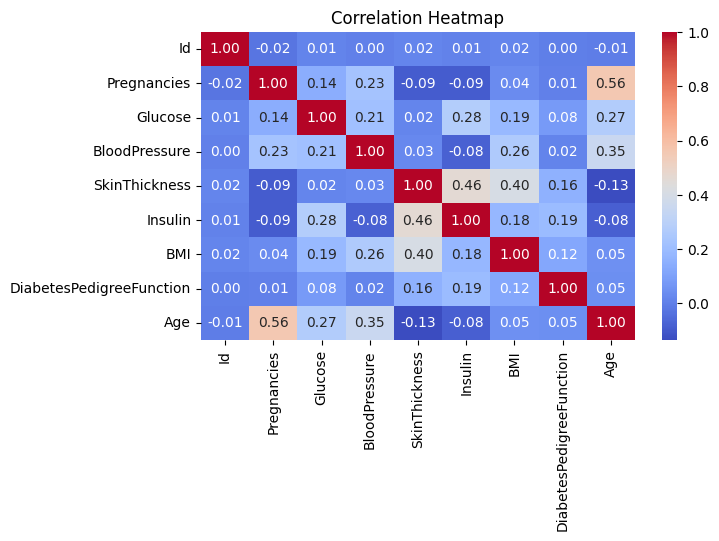

No PCA needed, feature count: 9

Feature Scaled Data:
shape: (2, 10)
┌───────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬─────────┐
│ Id        ┆ Pregnancie ┆ Glucose   ┆ BloodPres ┆ … ┆ BMI       ┆ DiabetesP ┆ Age       ┆ Outcome │
│ ---       ┆ s          ┆ ---       ┆ sure      ┆   ┆ ---       ┆ edigreeFu ┆ ---       ┆ ---     │
│ f64       ┆ ---        ┆ f64       ┆ ---       ┆   ┆ f64       ┆ nction    ┆ f64       ┆ u32     │
│           ┆ f64        ┆           ┆ f64       ┆   ┆           ┆ ---       ┆           ┆         │
│           ┆            ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆         │
╞═══════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═════════╡
│ -0.191013 ┆ 1.940449   ┆ -0.183207 ┆ 2.104947  ┆ … ┆ -1.243157 ┆ 2.014529  ┆ 0.084954  ┆ 1       │
│ 0.815294  ┆ -1.158514  ┆ -0.847928 ┆ 1.041242  ┆ … ┆ 0.773973  ┆ -0.735292 ┆ -0.787121 ┆ 0       │
└───────────┴─────────

In [87]:
dfse=FeatureEngineering(df)
df=dfse.select_n_extract()

In [88]:
dfse.__del__()
dfse.numarical_cols

FeatureEngineering object deleted


[]

In [89]:
df.head()

Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
f64,f64,f64,f64,f64,f64,f64,f64,f64,u32
-0.191013,1.940449,-0.183207,2.104947,-1.372169,-0.817307,-1.243157,2.014529,0.084954,1
0.815294,-1.158514,-0.847928,1.041242,0.256918,-0.417025,0.773973,-0.735292,-0.787121,0
-0.24114,1.320656,1.01329,0.468478,0.713063,1.517671,1.6019,0.219162,0.259369,0
0.107245,-0.848618,1.578303,1.286713,0.517572,-0.817307,0.412696,1.599394,1.654689,0
0.481947,-0.848618,-1.080581,0.468478,0.517572,0.027732,-0.0389,-0.316609,-0.351083,1


In [90]:
class TrainTest:
    def __init__(self, df):
        self.df = df

    # Define the function to accept *args
    def train_test_split(self, *args):
        # Split the DataFrame
        train_df = self.df[:args[0]]
        test_df = self.df[args[0]:]
        return train_df, test_df

    # Define the function to accept **kwargs
    def xy_split(self, **kwargs):
        split_index = int(len(self.df) * 0.7)  # 70% for training
        train_df, test_df = self.train_test_split(split_index)

        # Prepare features and target
        y_train = train_df["Outcome"]
        X_train = train_df.drop("Outcome")  # No axis argument needed
        y_test = test_df["Outcome"]
        X_test = test_df.drop("Outcome")  # No axis argument needed

        # Print additional kwargs
        for key, value in kwargs.items():
            print(f"{key}: {value}")

        return X_train, X_test, y_train, y_test


    def split_data(self):
        X_train, X_test, y_train, y_test = self.xy_split(df_length=len(self.df), df_mean=self.df["Age"].mean())

        # Print shapes
        print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
        return X_train, X_test, y_train, y_test

    def __del__(self):
        print("TrainTest object deleted")

In [91]:
dtt=TrainTest(df)
X_train, X_test, y_train, y_test=dtt.split_data()

df_length: 2477
df_mean: 2.873043838452666e-16
Train shape: (1733, 9) Test shape: (744, 9)


In [92]:
dtt.__del__()

TrainTest object deleted


In [93]:
from abc import ABC, abstractmethod
class ML_Model(ABC):
    @abstractmethod
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    @abstractmethod
    def train_model(self):
        pass

    @abstractmethod
    def evaluate_model(self):
        pass

    @abstractmethod
    def visualize_results(self):
        pass

    @classmethod
    @abstractmethod
    def save_model(cls, model, file_path):
        pass

    @abstractmethod
    def __del__(self):
        pass

In [94]:
class DecisionTree(ML_Model):
    y_pred = []

    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test)
        self.model = DecisionTreeClassifier(random_state=42)

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)
        print("Decision Tree model trained.")

    def evaluate_model(self):
        DecisionTree.y_pred = self.model.predict(self.X_test)
        # Calculate metrics
        acc = accuracy_score(self.y_test, DecisionTree.y_pred)
        prec = precision_score(self.y_test, DecisionTree.y_pred, average='weighted')
        rec = recall_score(self.y_test, DecisionTree.y_pred, average='weighted')
        f1 = f1_score(self.y_test, DecisionTree.y_pred, average='weighted')

        print(f"\nDecision Tree Results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")

    def visualize_results(self):
        cm = confusion_matrix(self.y_test, DecisionTree.y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
        plt.title('Decision Tree Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    @classmethod
    def save_model(cls, model, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model saved to {file_path}")

    def __del__(self):
        print("DecisionTree object deleted")

Decision Tree model trained.

Decision Tree Results:
Accuracy: 0.9637
Precision: 0.9637
Recall: 0.9637
F1-Score: 0.9637
DataNormaliseStandardise object deleted


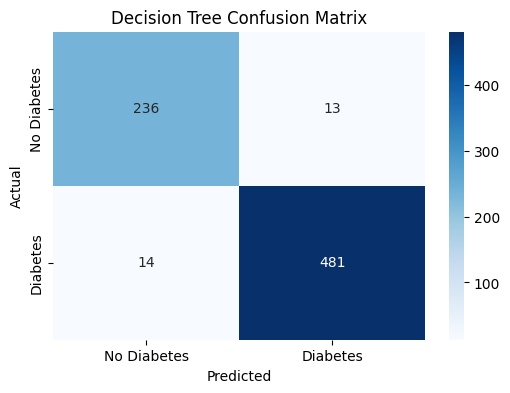

Model saved to decision_tree_model.pkl


In [95]:
mod_dt = DecisionTree(X_train, X_test, y_train, y_test)
mod_dt.train_model()
mod_dt.evaluate_model()
mod_dt.visualize_results()
DecisionTree.save_model(mod_dt.model, 'decision_tree_model.pkl')

In [96]:
class RandomForest(ML_Model):
    y_pred = []
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test)
        self.model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)
        print("Random Forest model trained.")

    def evaluate_model(self):
        RandomForest.y_pred = self.model.predict(self.X_test)
        # Calculate metrics
        acc = accuracy_score(self.y_test, RandomForest.y_pred)
        prec = precision_score(self.y_test, RandomForest.y_pred, average='weighted')
        rec = recall_score(self.y_test, RandomForest.y_pred, average='weighted')
        f1 = f1_score(self.y_test, RandomForest.y_pred, average='weighted')

        print(f"\nRandom Forest Results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")

    def visualize_results(self):
        cm = confusion_matrix(self.y_test, RandomForest.y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
        plt.title('Random Forest Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    @classmethod
    def save_model(cls, model, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model saved to {file_path}")

    def __del__(self):
        print("RandomForest object deleted")

Random Forest model trained.

Random Forest Results:
Accuracy: 0.9516
Precision: 0.9515
Recall: 0.9516
F1-Score: 0.9514


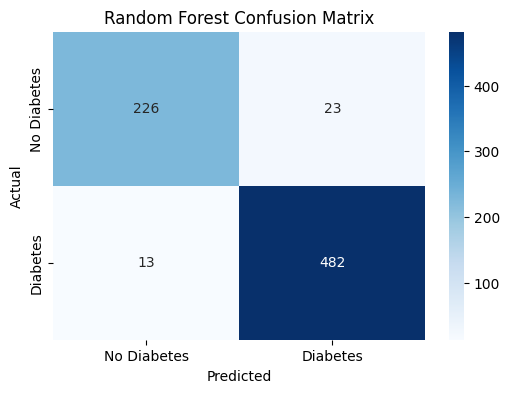

Model saved to random_forest_model.pkl


In [97]:
mod_rf = RandomForest(X_train, X_test, y_train, y_test)
mod_rf.train_model()
mod_rf.evaluate_model()
mod_rf.visualize_results()
RandomForest.save_model(mod_rf.model, 'random_forest_model.pkl')

In [98]:
class XGBoost(ML_Model):
    y_pred = []
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test)
        self.model = xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=4)

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)
        print("XGBoost model trained.")

    def evaluate_model(self):
        XGBoost.y_pred = self.model.predict(self.X_test)
        # Calculate metrics
        acc = accuracy_score(self.y_test, XGBoost.y_pred)
        prec = precision_score(self.y_test, XGBoost.y_pred, average='weighted')
        rec = recall_score(self.y_test, XGBoost.y_pred, average='weighted')
        f1 = f1_score(self.y_test, XGBoost.y_pred, average='weighted')
        print(f"\nXGBoost Results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"F1-Score: {f1:.4f}")

    def visualize_results(self):
        cm = confusion_matrix(self.y_test, XGBoost.y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
        plt.title('XGBoost Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    @classmethod
    def save_model(cls, model, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(model, file)
        print(f"Model saved to {file_path}")

    def __del__(self):
        print("XGBoost object deleted")

XGBoost model trained.

XGBoost Results:
Accuracy: 0.9005
Precision: 0.9000
Recall: 0.9005
F1-Score: 0.8992


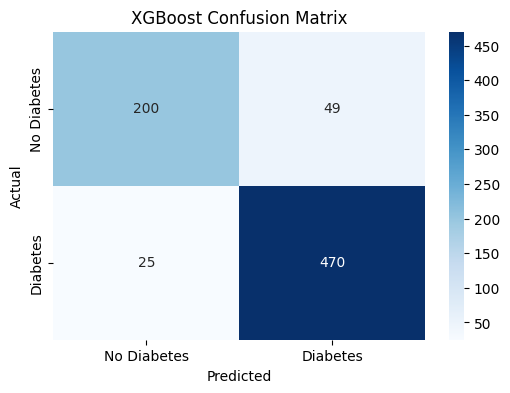

Model saved to xgboost_model.pkl


In [99]:
mod_xgb = XGBoost(X_train, X_test, y_train, y_test)
mod_xgb.train_model()
mod_xgb.evaluate_model()
mod_xgb.visualize_results()
XGBoost.save_model(mod_xgb.model, 'xgboost_model.pkl')

In [106]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
model = pickle.load(open("xgboost_model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))
label_encoders = pickle.load(open("label_encoders.pkl", "rb"))  # Dict of encoders
selected_columns = pickle.load(open("selected_cols.pkl", "rb"))

# --- Manual input ---
sample_input = {
    'Id': 12, # Added dummy Id
    'Pregnancies': 3,
    'Glucose': 140,
    'BloodPressure': 70,
    'SkinThickness': 20,
    'Insulin': 85,
    'BMI': 32.4,
    'DiabetesPedigreeFunction': 0.6,
    'Age': 45,
    'Quote': "Live well",        # Categorical Optional (may or may not provided by default it will be "Live well")
    'City': "Houston",           # Categorical Optional (may or may not provided by default it will be "Houston")
    'Outcome': "Diabetes"        # Needed only if you want to compare
}

# --- Convert to DataFrame ---
sample_df = pd.DataFrame([sample_input])
sample_df = pl.from_pandas(sample_df)

# --- Encode categorical using saved label_encoders ---
for col in ['Quote', 'City', 'Outcome']:
    le = label_encoders[col]
    sample_df = sample_df.with_columns(
        pl.Series(col, le.transform(sample_df[col].to_pandas())).cast(pl.UInt32).alias(col)
    )

# --- Scale numeric columns ---
numeric_cols = ['Id', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] # Added Id to numeric_cols
sample_df_pandas = sample_df.to_pandas()
sample_df_pandas[numeric_cols] = scaler.transform(sample_df_pandas[numeric_cols])

# --- Convert back to Polars ---
sample_df = pl.from_pandas(sample_df_pandas)

# --- Select only final features ---
sample_df = sample_df.select(selected_columns)

# --- Predict ---
prediction = model.predict(sample_df.to_pandas())[0]
pred_label = "Diabetes" if prediction == 1 else "No Diabetes"

print(f"Prediction: {pred_label}")

Prediction: No Diabetes
